# Day 14 notebook

The objectives of this notebook are to practice

* simulating DNA sequence evolution
* computing distances from sequences

We will practice these tasks by building a DNA sequence evolution simulator, that takes as input a phylogenetic tree and a sequence for the ancestral (root) node of the tree.  The simulation task will be broken down into three steps:
1. Converting branch lengths to substitution probabilities (problem 1)
2. Evolving a sequence along a single branch of the tree (problem 2)
3. Evolving sequences over the entire tree (provided)

We will then perform a simulation and compute the pairwise distance matrix of the resulting leaf sequences (problem 3), as one would do in the first step of a distance-based phylogenetic tree method.  Lastly, we will see how the pairwise distance matrix compares with the original tree.

## Modules used for this assignment

In [2]:
# standard library modules
import math                   # for log and exp
import random                 # for random sampling
import collections            # for Counter

# third-party modules
import numpy                  # for sampling from a binomial distribution
import toytree                # for working with trees
from matplotlib import pyplot # for plotting

## The `toytree` module and Newick format

In this activity we will use again use the [`toytree` module](https://toytree.readthedocs.io/en/latest/4-tutorial.html) to work with phylogenetic trees and [Newick format](https://en.wikipedia.org/wiki/Newick_format) to specify trees.

## PROBLEM 1: Converting branch lengths to substitution probabilities (1 POINT)
The branch lengths of phylogenetic trees often represent the number of mutation events that have occurred along that branch, from the parent sequence to the child sequence.  More precisely, branch lengths are often measured in terms of *expected substitutions per site*, which is essentially the average number of mutations that have occurred at each position within the sequence.  This differs from the frequency of mismatches between the child and parent sequences because multiple mutations may occur at the same site.  Recall that the Jukes—Cantor correction is a way to estimate a distance from an observed frequency of mismatches between two sequences.  The equation for this correction is:
$d = -\frac{3}{4}\log(1 - \frac{4}{3}f)$
where $f$ is the fraction of positions in the two sequences that are mismatched.  This equation is implemented in the function below.
 

In [3]:
def jukes_cantor_distance(mismatch_prob):
    """Computes the Jukes Cantor distance estimate given a frequency of mismatches.
    
    Args:
        mismatch_prob: The frequency of mismatches in a sequence (floating point value in [0, 1])
    Returns:
        The Jukes Cantor distance estimate (floating point value in [0, ∞) )
    """
    
    """Returns the Jukes Cantor distance estimate given a frequency of mismatches."""
    return -3/4 * math.log(1 - 4/3 * mismatch_prob) if mismatch_prob < 0.75 else float("inf")

For the purposes of simulation, we will need to convert branch lengths (distances) to the probability of a given site having a mismatch.  Implement the *inverse* of the Juke Cantor distance below:

In [4]:
def mismatch_prob_from_distance(distance):
    """Computes a frequency/probability of mismatches given a distance, assuming the Jukes Cantor model.
    
    Args:
        distance: a non-negative floating point value
    Returns:
        The expected frequency of mismatches in a sequence (a floating point value in [0, 0.75])
    """
    ###
    ### YOUR CODE HERE
    # d = distance
    # d = d * (-4/3)
    # d = math.exp(d)
    # d = d - 1
    # d = d * (-3/4)
    # return d

    return (math.exp(-4*distance/3)-1)*(-3/4)

In [5]:
# tests for mismatch_prob_from_distance
assert mismatch_prob_from_distance(0) == 0
assert mismatch_prob_from_distance(float("inf")) == 0.75
assert round(mismatch_prob_from_distance(0.01), 2) == 0.01
assert round(mismatch_prob_from_distance(1), 2) == 0.55
print("SUCCESS: mismatch_prob_from_distance passed all tests")

SUCCESS: mismatch_prob_from_distance passed all tests


Let's plot this inverse function.

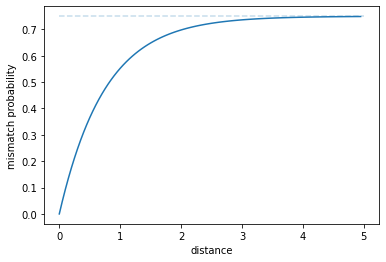

In [6]:
num_points = 100
max_distance = 5
distances = [max_distance * (i / num_points) for i in range(num_points)]
mismatch_probs = list(map(mismatch_prob_from_distance, distances))
pyplot.plot(distances, mismatch_probs)
pyplot.xlabel("distance")
pyplot.ylabel("mismatch probability")
pyplot.hlines(0.75, 0, max_distance, linestyles="dashed", alpha=0.25)
pyplot.show()

## PROBLEM 2: Simulating DNA sequence evolution (1 POINT)
We will now implement a function that simulates DNA sequence evolution along a single branch in a tree.  For simplicity, we will only consider subsitutions (i.e., not insertions or deletions) in this simulation.  The top level function for this is given below, which takes as input a parent sequence and an evolutionary distance, and returns an evolved child sequence.  It calls your `mismatch_prob_from_distance` function from above to compute the probablity of a mismatch at any given position and then samples from a binomial distribution with this probability to determine the number of mismatches in the child sequence.  You are to provide the function `mutate_sequence`, which is given a parent sequence and a number of mismatches, and returns a sequence with the given number of mismatches with respect to the parent, and with mismatched positions selected uniformly and at random across the sequence.  I have provided the function `mutate_base` which I recommend that you use to randomly sample a mismatched base for a given position.

In [7]:
def evolve_sequence(parent_seq, distance):
    """Evolves a DNA sequence over a given evolutionary distance.
    
    Args:
        parent_seq: the parent DNA sequence (a string)
        distance: the distance over which to evolve the sequence (a non-negative float)
    Returns:
        The child (evolved) sequence.
    """
    p_mismatch = mismatch_prob_from_distance(distance)
    num_mismatches = numpy.random.binomial(len(parent_seq), p_mismatch)
    return mutate_sequence(parent_seq, num_mismatches)

In [8]:
BASES = "ACGT"
MUTANTS = {base: BASES.replace(base, '') for base in BASES}
def mutate_base(base):
    """Returns a randomly sampled base that mismatches with the base given as input."""
    return random.choice(MUTANTS[base])

You are to fill in the function below.  I recommend that you use the [`random.sample`](https://docs.python.org/3/library/random.html#random.sample) function to sample the positions at which there are mismatches.

In [43]:
def mutate_sequence(seq, num_mismatches):
    """Mutates a DNA sequence at a given number of randomly selected positions.

    Args:
        seq: the original sequence (a string)
        num_mismatches: the number of mismatches that the mutated sequence should
                        have with respect to the original sequence.
    Returns:
        The mutated sequence as a string.
    """
    ###
    ### YOUR CODE HERE

    mismatch_positions = random.sample(range(len(seq)), num_mismatches)
    evolved = list(seq)
    for i in mismatch_positions:
        evolved[i] = mutate_base(evolved[i])
    return ''.join(evolved)


The functions below will be useful for counting mismatches in alignments.

In [44]:
def num_alignment_mismatches(alignment):
    """Returns the number of mismatched positions in the given ungapped alignment."""
    return sum(c1 != c2 for c1, c2 in zip(*alignment))

def mismatched_alignment_positions(alignment):
    """Returns a list of the positions at which there are mismatches in the given ungapped alignment."""
    return [i for i, (c1, c2) in enumerate(zip(*alignment)) if c1 != c2]

In [45]:
# tests for mutate_sequence
seq = "TACTACTATTTTCGTACCGA"
assert mutate_sequence(seq, 0) == seq
assert num_alignment_mismatches([seq, mutate_sequence(seq, 1)]) == 1
assert num_alignment_mismatches([seq, mutate_sequence(seq, 7)]) == 7
assert num_alignment_mismatches([seq, mutate_sequence(seq, len(seq))]) == len(seq)

num_trials = 5000
num_mismatches = 4
mismatch_counts = collections.Counter()
for i in range(num_trials):
    alignment = [seq, mutate_sequence(seq, num_mismatches)]
    mismatch_counts.update(mismatched_alignment_positions(alignment))
mismatch_freqs = [round(mismatch_counts[i] / num_trials, 1) for i in range(len(seq))]
# With 4 mismatches the average number of times that each position is mismatched should be 0.2
# this assertion should pass with very high probability
assert mismatch_freqs == [num_mismatches / len(seq)] * len(seq)
print("SUCCESS: mutate_sequence passed all tests")

SUCCESS: mutate_sequence passed all tests


### A function for simulating evolution along an entire tree
Finally, here is a function that performs an evolutionary simulation along an entire tree.

In [46]:
def evolve_sequences_along_tree(ancestral_seq, newick_tree):
    """Evolves DNA sequences along a tree given an ancestral sequence at the root.

    The ancestral sequence is assigned to the root node and evolution is simulated along 
    each branch according to the branch lengths.
    
    Args:
        ancestral_seq: the ancestral DNA sequence
        newick_tree: A newick string specifying the tree
    Returns:
        A toytree.tree object with simulated evolved sequences assigned to each node.
    """
    tree = toytree.tree(newick_tree)
    for node in tree.treenode.traverse("preorder"):
        if node.is_root():
            node_seq = ancestral_seq
        else:
            node_seq = evolve_sequence(node.up.sequence, node.dist)
        node.add_feature("sequence", node_seq)
    return tree

The following function will be useful for extracting the resulting leaf sequences from the tree.

In [47]:
def leaf_sequences(tree):
    """Returns a dictionary of the leaf names mapped to their sequences for the given toytree.tree."""
    return {leaf.name: leaf.sequence for leaf in tree.treenode}

Here are some test runs of the simulator with small trees and an ancestral sequence that is all As (so that it is easier to visualize where the subsitutions have occurred).

In [48]:
ancestral_sequence = "A" * 40
newick1 = "((A:0.05, B:0.05):0.25, (C:0.15, D:0.15):0.15);"
test_tree1 = evolve_sequences_along_tree(ancestral_sequence, newick1)
newick2 = "(((A:0.1, B:0.05):0.1, (C:0.2, D:0.15):0.15):0.05, E:0.25);"
test_tree2 = evolve_sequences_along_tree(ancestral_sequence, newick2)

def tip_labels_with_seqs(tree):
    leaf_seqs = leaf_sequences(tree)
    label_format = "{}: {}"
    return [label_format.format(name, leaf_seqs[name]) for name in tree.get_tip_labels()]

tip_labels_style = {"font-family": "monospace", "font-size": "15px"}

test_tree1.draw(tree_style="o", node_labels=False, width=1200, 
                tip_labels=tip_labels_with_seqs(test_tree1),
                tip_labels_style=tip_labels_style);

test_tree2.draw(tree_style="o", node_labels=False, width=1200, 
                tip_labels_align=True,
                tip_labels=tip_labels_with_seqs(test_tree2),
                tip_labels_style=tip_labels_style);

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="275.0px" viewBox="0 0 1200.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t8ea250b522964d2696777a8370892ee9"> D: AAAAAAAAAAATAAAGAACAATAAAACACAAAGGAAAAAA C: AAAACAAAAAAAAAAGAACAATAAAAAGAAAGACAAAACA B: AAAAAAAGAAATAGATAAAATAAAATTACAAACAAACAAA A: AAAAAAAGAAGTAGATAAAATAAAATAAAAAACAAGCAAA

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1200.0px" height="275.0px" viewBox="0 0 1200.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tca1808de3671409896711c30eec5b312"> D: AAAAAAAAAAAAACAAAAAAGAAAACCAAGAAGACGAAGC C: AACTATAAAAAAATCAAAATGAAACATAACTCGAGGTAGG B: AAAAGAGAAAACATAAAAAAAAAAAACAAAAGAAGGTAGT A: AAAAGAGAAAAAATAAAAAAAAAAAACAAAAGCAGGTCGA E: AAACAAAAAGAAAAATAAAACAAAAAAATAAAAAGAAAAA

## PROBLEM 3: Computing pairwise distances between sequences (1 POINT)
We will now write a function that computes all pairwise distances for a set of sequences.  The function will take as input a dictionary mapping names to sequences and the output will be a dictionary mapping pairs (two element tuples) of names to pairwise distances of the corresponding sequences.  Your function should use the `jukes_cantor_distance` function and you may find the `num_alignment_mismatches` function defined above of use.  Note that we are not including insertions or deletions in our simulations, so the pairwise alignments between the sequences are trivial.

In [49]:
def compute_pairwise_distances(sequences):
    """Computes the pairwise distance matrix for the given set of DNA sequences.
    
    Args:
        sequences: a dictionary mapping names to sequences.
    Returns:
        A pairwise distance matrix in the form of a dictionary that maps pairs (tuples)
        of names to pairwise distances of the corresponding sequences.  The output matrix
        will be symmetric (i.e., both (a, b) and (b, a) will map to the same distance value).
    """    
    ###
    ### YOUR CODE HERE
    d = {}
    for name1, seq1 in sequences.items():
        for name2, seq2 in sequences.items():
            pair_distance = jukes_cantor_distance(num_alignment_mismatches([seq1, seq2]) / len(seq1))
            d[(name1, name2)] = d[(name2, name1)] = pair_distance
    return d


In [50]:
# tests for compute_pairwise_distances
def round_dict(d, digits=2):
    return {key: round(value, 2) for key, value in d.items()}
test_seqs1 = {
    'A': 'AAAAACAAAAAAAGCAAAGGAAAAAGATTGAAATGAAAAA',
    'B': 'AAAAACATAAAATCCAAAGGAAAAAGATGCAAATGAAAAA',
    'C': 'AAAAAAAGAAAAGAAGAAAAAGATAAAATACAAAAAAAAA',
    'D': 'AAGAACAGAAAAAAAAAAGAACATAAAAGACAAAAAAAAA'}
test_dists1 = {
    ('A', 'A'): 0,    ('A', 'B'): 0.14, ('A', 'C'): 0.57, ('A', 'D'): 0.47,
    ('B', 'A'): 0.14, ('B', 'B'): 0,    ('B', 'C'): 0.63, ('B', 'D'): 0.47,
    ('C', 'A'): 0.57, ('C', 'B'): 0.63, ('C', 'C'): 0,    ('C', 'D'): 0.2,
    ('D', 'A'): 0.47, ('D', 'B'): 0.47, ('D', 'C'): 0.2,  ('D', 'D'): 0}
assert round_dict(compute_pairwise_distances(test_seqs1)) == test_dists1

test_seqs2 = {
    'A': 'CATCTAG',
    'B': 'CATCTAG',
    'C': 'CATCTAG'}
test_dists2 = {
    ('A', 'A'): 0, ('A', 'B'): 0, ('A', 'C'): 0,
    ('B', 'A'): 0, ('B', 'B'): 0, ('B', 'C'): 0,
    ('C', 'A'): 0, ('C', 'B'): 0, ('C', 'C'): 0}
assert round_dict(compute_pairwise_distances(test_seqs2)) == test_dists2

test_seqs3 = {
    'A': 'AAAAATAAAAAAATAGTCAAAAATTAAAAAAACAAAAAAA',
    'B': 'AAAAATAAAAAAATAAACAAAAATAAAAAAAAAAAAAAAA',
    'C': 'AAGACTGAAAAACGAAAGGAACAGTAGACCATAATAAAGA',
    'D': 'AAAAATAAAAAAAGAAAGGAAAAAAAAAACAAAATAAAGA',
    'E': 'GCGGAAAAGAAAAGATATAAAAAAAAAAAATTTACGAAAA'}
test_dists3 = {
    ('A', 'A'): 0,    ('A', 'B'): 0.11, ('A', 'C'): 0.69, ('A', 'D'): 0.34, ('A', 'E'): 0.63,
    ('B', 'A'): 0.11, ('B', 'B'): 0,    ('B', 'C'): 0.57, ('B', 'D'): 0.2,  ('B', 'E'): 0.52, 
    ('C', 'A'): 0.69, ('C', 'B'): 0.57, ('C', 'C'): 0,    ('C', 'D'): 0.3,  ('C', 'E'): 0.99,
    ('D', 'A'): 0.34, ('D', 'B'): 0.2,  ('D', 'C'): 0.3,  ('D', 'D'): 0,    ('D', 'E'): 0.57,
    ('E', 'A'): 0.63, ('E', 'B'): 0.52, ('E', 'C'): 0.99, ('E', 'D'): 0.57, ('E', 'E'): 0}
assert round_dict(compute_pairwise_distances(test_seqs3)) == test_dists3
print("SUCCESS: compute_pairwise_distances passed all tests")

SUCCESS: compute_pairwise_distances passed all tests


## Bonus exploration

Try some simulations and compute the pairwise distance marix for each result.

1. How well do the pairwise distances match the tree?
2. Do the pairwise distances satisfy the ultrametric property?
3. How do your results (and answers to 1 and 2) change as you increase the length of the sequences?

###
### Your results here
###
